## Section 1: Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.dates as md
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [ ]:
import os

os.chdir('/content/drive/MyDrive/Colab Notebooks/portfolio')

!pwd

/content/drive/MyDrive/Colab Notebooks/portfolio


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import 
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.4.1


##Section 2: Data Loading and Cleaning 

In [ ]:
dataf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/portfolio/S&P_500_Index_Data.csv',parse_dates=['date'])
dataf.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [ ]:
dataf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8192 entries, 0 to 8191
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    8192 non-null   datetime64[ns]
 1   close   8192 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 128.1 KB


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dataf.date, y=dataf.close, mode='lines', name='close'))
fig.update_layout(showlegend=True)
fig.show()

##Section 3: Data Preprocessing

In [ ]:
train_size = int(len(dataf) * 0.8)
test_size = len(dataf) - train_size
train, test = dataf.iloc[0:train_size], dataf.iloc[train_size:len(dataf)]
print(train.shape, test.shape)

(6553, 2) (1639, 2)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

#Section 4: Creating data set for training and testing splits

In [ ]:
def create_sequences(X,y, time_steps=1):
  Xs, ys = [] , []
  for i in range(len(X) - time_steps):
    Xs.append(X.iloc[i:(i+time_steps)].values)
    ys.append(y.iloc[i+time_steps])
  return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 30

X_train, y_train = create_sequences(train[['close']], train.close, time_steps)
X_test, y_test = create_sequences(test[['close']], test.close, time_steps)


In [ ]:
print(X_train.shape)

(6523, 30, 1)


##Section 5: Model Development

In [ ]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
                    LSTM(128, input_shape=(timesteps, num_features)),
                    Dropout(0.2),
                    RepeatVector(timesteps),
                    LSTM(120, return_sequences=True),
                    Dropout(0.2),
                    TimeDistributed(Dense(num_features))
                    
])

model.compile(loss='mae', optimizer ='adam')
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 120)           119520    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 120)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             121       
Total params: 186,201
Trainable params: 186,201
Non-trainable params: 0
__________________________________________________

##Section 6: Autoencoder training

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
    X_train, y_train,
    epochs = 100,
    batch_size = 32,
    validation_split=0.1,
    callbacks = [es],
    shuffle= False  
)

Epoch 1/100
184/184 [==============================] - 17s 74ms/step - loss: 0.2526 - val_loss: 0.2197
Epoch 2/100
184/184 [==============================] - 12s 67ms/step - loss: 0.1839 - val_loss: 0.0843
Epoch 3/100
184/184 [==============================] - 12s 67ms/step - loss: 0.1214 - val_loss: 0.0557
Epoch 4/100
184/184 [==============================] - 12s 67ms/step - loss: 0.1089 - val_loss: 0.0404
Epoch 5/100
184/184 [==============================] - 12s 67ms/step - loss: 0.0949 - val_loss: 0.0377
Epoch 6/100
184/184 [==============================] - 12s 67ms/step - loss: 0.0950 - val_loss: 0.0536
Epoch 7/100
184/184 [==============================] - 12s 67ms/step - loss: 0.1067 - val_loss: 0.0893
Epoch 8/100
184/184 [==============================] - 12s 67ms/step - loss: 0.1118 - val_loss: 0.0496


##Model Evaluation

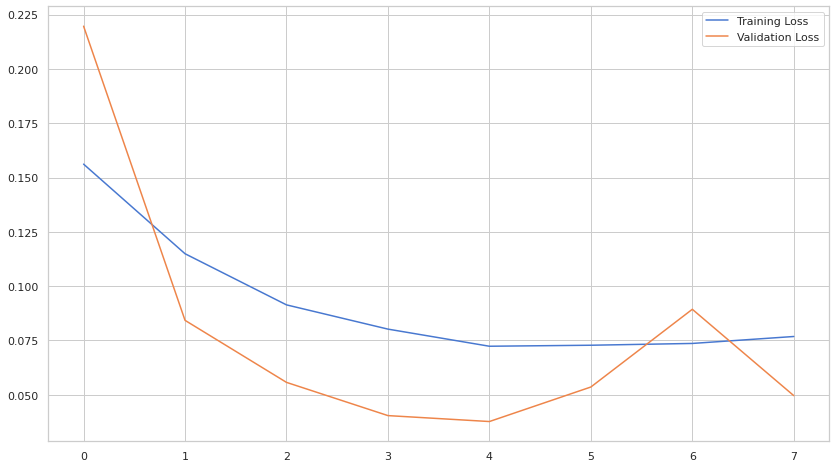

In [ ]:
plt.plot(history.history['loss'], label ='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()

In [ ]:
X_train_pred = model.predict(X_train)
train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

In [ ]:
model.evaluate(X_test, y_test)

51/51 [==============================] - 1s 20ms/step - loss: 0.3319


0.331942081451416

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



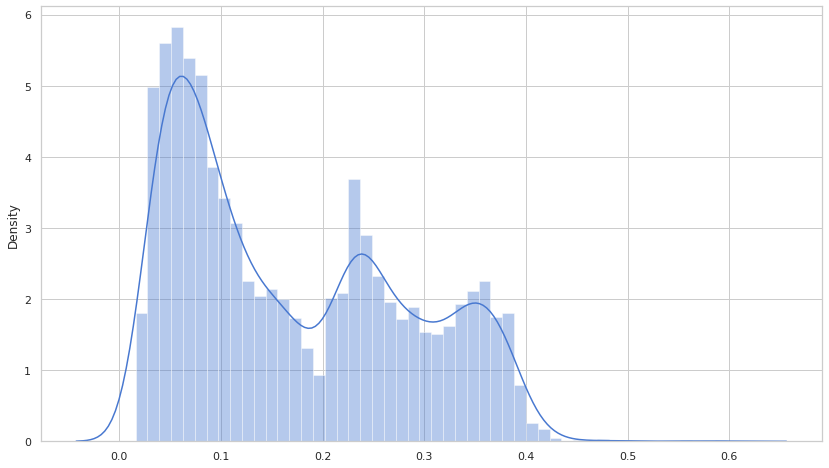

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [ ]:
threshold = 0.65

In [ ]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

##Section 8: Anomaly Detection

In [ ]:
test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [ ]:
test_score_df.tail()

,date,close,loss,threshold,anomaly
8187,2018-06-25,4.493228,0.688393,0.65,True
8188,2018-06-26,4.507583,0.725012,0.65,True
8189,2018-06-27,4.451431,0.738815,0.65,True
8190,2018-06-28,4.491406,0.766156,0.65,True
8191,2018-06-29,4.496343,0.763856,0.65,True


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss,
                         mode='lines', name = 'Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold,
                        mode='lines', name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()



In [ ]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,date,close,loss,threshold,anomaly
7475,2015-08-26,2.632149,0.721207,0.65,True
7476,2015-08-27,2.745147,0.671852,0.65,True
8090,2018-02-05,4.329949,0.673645,0.65,True
8091,2018-02-06,4.440671,0.812872,0.65,True
8092,2018-02-07,4.408365,0.844026,0.65,True


In [ ]:
!pip install kaleido

     |████████████████████████████████| 74.6MB 68kB/s 


In [ ]:
!pwd

/content/drive/My Drive/Colab Notebooks/portfolio


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=test[time_steps:].date, y=scaler.inverse_transform(test[time_steps:].close),
                         mode='lines', name = 'Close price'))
fig.add_trace(go.Scatter(x=anomalies.date, y=scaler.inverse_transform(anomalies.close),
                         mode='markers', name='Anomaly'))
fig.update_layout(xaxis_title="Year",
                  yaxis_title="Stock Price",
                  showlegend=True)
fig.show()



TypeError: ignored